In [1]:
import os
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn import tree
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
path = 'F:\\2020-21\\Beca VRAIN\\datasets\\data_train\\'

cuotaNatDB = pd.read_csv(path + 'cuotaNatDB.csv')
cuotasDB = pd.read_csv(path + 'cuotas3DB.csv')
cuotasDB_tend5 = pd.read_csv(path + 'cuotas3DB_tend5.csv')

In [3]:
cuotasDB

B365H  B365A  res
0      2.40   2.90    1
1      4.00   1.85    1
2      3.10   2.25   -1
3      1.53   5.75   -1
4      1.53   6.00   -1
...     ...    ...  ...
1821   1.62   5.50    0
1822   8.00   1.45    0
1823   2.38   3.20    1
1824   1.75   4.50   -1
1825   2.05   4.10   -1

[1826 rows x 3 columns]

In [4]:
# funcion para normalizar/estandarizar DB

def normalDB(db,scaler='', col_res='res',**conf):
    
    db = db.dropna()
    
    if scaler=='':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        
    res  = list(db[col_res])  # tiene que ser list() porque sino se guardan los indices también
    data = db.drop(col_res,axis=1)
    cols = data.columns
    
    assert len(db) == len(res) == len(data)
    
    scaler.fit(data)
    data = scaler.transform(data)
    
    data = pd.DataFrame(data,columns=cols)
    data[col_res] = res
    
    return data

In [5]:
def preprocessDB(db,frac=0.85,col_res='res',seed=1):
    db = db.sample(frac=1,axis=0,random_state=seed)
    index = int(len(db)*frac)
    y = db[col_res]
    X = db.drop(col_res,axis=1)
    trainX = X[:index]
    testX  = X[index:]
    trainY = y[:index]
    testY  = y[index:]
    
    trainDB = db[:index]
    
    return trainDB,trainX,trainY,testX,testY

<h2><u>CUOTAS DB</u></h2>

<h3>Antes que nada vamos a visualizar el Dataset más básico que tenemos</h3>

Antes que nada vamos a transformar las cuotas en probabilidades

In [6]:
cuotasDB['B365H'] = [1/x for x in list(cuotasDB['B365H'])]
cuotasDB['B365A'] = [1/x for x in list(cuotasDB['B365A'])]

In [7]:
max(cuotasDB['B365A'])

0.8849557522123894

In [30]:
cuotasDB

B365H     B365A  res
0     0.416667  0.344828    1
1     0.250000  0.540541    1
2     0.322581  0.444444   -1
3     0.653595  0.173913   -1
4     0.653595  0.166667   -1
...        ...       ...  ...
1821  0.617284  0.181818    0
1822  0.125000  0.689655    0
1823  0.420168  0.312500    1
1824  0.571429  0.222222   -1
1825  0.487805  0.243902   -1

[1826 rows x 3 columns]

In [32]:
# Cual es el margen que dejan las casas de apuestas sin asignar?

margen = [abs(h-a) for h,a in zip(cuotasDB['B365H'],cuotasDB['B365A'])]
sum(margen) / len(margen)

0.3472413657889949

<AxesSubplot:xlabel='B365H', ylabel='B365A'>

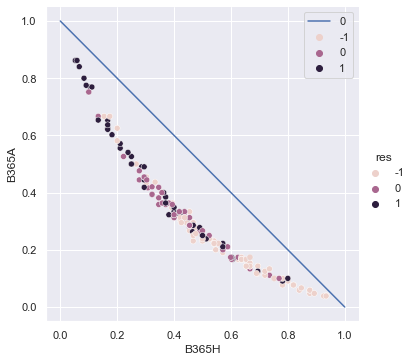

In [53]:
sns.set_theme()

sns.relplot(
    data=cuotasDB.sample(frac=0.1,axis=0),
    x="B365H", y="B365A",
    hue="res"
)

sns.lineplot(
    data=[[1,0]],
)

Lo siguiente, habrá que normalizar los datos

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
col = list(cuotasDB.columns)

In [11]:
scaler.fit(cuotasDB[col[:2]])

MinMaxScaler()

In [12]:
cuotasDB_norm = scaler.transform(cuotasDB[col[:2]])
cuotasDB_norm = pd.DataFrame(cuotasDB_norm,columns=col[:2])
cuotasDB_norm['res'] = cuotasDB['res']
cuotasDB_norm

B365H     B365A  res
0     0.403808  0.368673    1
1     0.221443  0.597431    1
2     0.300860  0.485110   -1
3     0.663052  0.168900   -1
4     0.663052  0.160430   -1
...        ...       ...  ...
1821  0.623321  0.178140    0
1822  0.084669  0.771724    0
1823  0.407639  0.330887    1
1824  0.573146  0.225366   -1
1825  0.481646  0.250707   -1

[1826 rows x 3 columns]

In [13]:
max(cuotasDB_norm['B365H'])

1.0

In [14]:
DB = cuotasDB_norm.sample(frac=1,axis=0,random_state=1)
# guardamos 275 para el Test
trainDB = DB[:-275]
testDB  = DB[-275:]

Para representar los datos vamos a coger solo una porción aleatoria (5%) de los datos de entrenamiento

<AxesSubplot:xlabel='B365H', ylabel='B365A'>

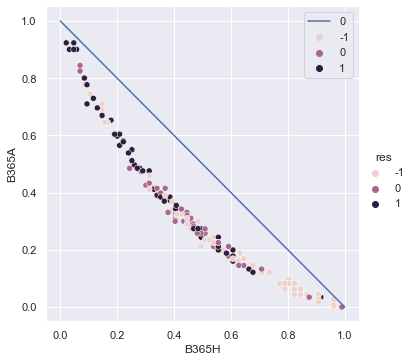

In [55]:
sns.relplot(
    data=trainDB.sample(frac=0.1,axis=0),
    x="B365H", y="B365A",
    hue="res"
)

sns.lineplot(
    data=[[1,0]],
)

# DUDA!!! Es probable que ambas variables sean dependientes. Lo son?
# y = 1/x ???

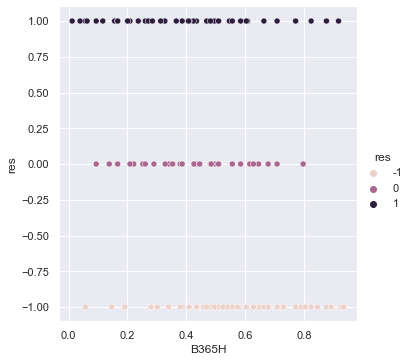

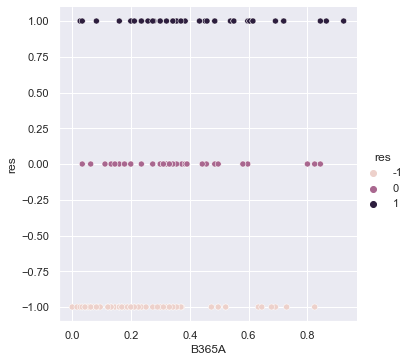

In [56]:
sns.relplot(
    data=trainDB.sample(frac=0.1,axis=0),
    x="B365H",y='res',
    hue="res"
)
sns.relplot(
    data=trainDB.sample(frac=0.1,axis=0),
    x="B365A",y='res',
    hue="res"
)

In [18]:
trainX = trainDB[col[:2]]
trainY = trainDB[col[-1]]

<h4>LDA</h4>

<h2>Modelos de predicción básicos</h2>

<h3>Árbol de decisión</h3>

Some advantages of decision trees are:

- Simple to understand and to interpret. Trees can be visualised.

- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.

- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.

- Able to handle both numerical and categorical data. However scikit-learn implementation does not support categorical variables for now. Other techniques are usually specialised in analysing datasets that have only one type of variable. See algorithms for more information.

- Able to handle multi-output problems.

- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.

- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.

- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

In [49]:
from sklearn import tree
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [16]:
clf = tree.DecisionTreeClassifier()

In [63]:
# clf = clf.fit(trainX, trainY)
scores = cross_val_score(clf,trainX,trainY,cv=5,)
scores.mean()

0.4841925111502956

In [19]:
results = cross_validate(clf,trainX,trainY,cv=5,return_estimator=True)
results['test_score'].mean()

0.48290218856965045

In [20]:
results

{'fit_time': array([0.00351095, 0.        , 0.00799704, 0.00801873, 0.0079658 ]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'estimator': [DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier()],
 'test_score': array([0.50160772, 0.46129032, 0.48064516, 0.49354839, 0.47741935])}

In [75]:
# visualizar el árbol
def tree_png(c,c_names,ft_names):
    from sklearn.tree import export_graphviz
    from six import StringIO  
    from IPython.display import Image  
    import pydotplus

    dot_data = StringIO()
    export_graphviz(c, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = ft_names,class_names=c_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('diabetes.png')
    return Image(graph.create_png())
    

In [76]:
tree_png(c=results['estimator'][0],c_names=['-1','0','1'], ft_names=col[:2])

<b>Optimización de Hiperparámetros para buscar un mejor rendimiento</b>

In [77]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Vamos a optimizar los hiperparámetros usando Validación Cruzada no-Anidada y Anidada

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py

In [50]:
from sklearn.model_selection import GridSearchCV

In [37]:
param = {
    'criterion':["gini","entropy"],
    'splitter':["best","random"],
    'random_state':[None,1],
}

# añadir min_samples_leaf y otros param de hojas

In [23]:
# Sin Anidar

clf_grid = GridSearchCV(estimator=clf, param_grid=param, cv=5)
clf_grid.fit(trainX,trainY)
clf_grid.best_score_

0.49129343429104866

In [24]:
clf_grid.cv_results_

{'mean_fit_time': array([0.00479121, 0.00319786, 0.00639515, 0.00472913, 0.        ,
        0.00312376, 0.006249  , 0.00313077]),
 'std_fit_time': array([0.00391202, 0.00391656, 0.00319762, 0.00627905, 0.        ,
        0.00624752, 0.00765343, 0.00626154]),
 'mean_score_time': array([0.00320396, 0.00159883, 0.00160522, 0.        , 0.00312419,
        0.        , 0.        , 0.00312424]),
 'std_score_time': array([0.00392405, 0.00319767, 0.00321045, 0.        , 0.00624838,
        0.        , 0.        , 0.00624847]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy', 'entropy'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_random_state': masked_array(data=[None, None, 1, 1, None, None, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 

In [81]:
clf_grid.best_params_

{'criterion': 'entropy', 'random_state': None, 'splitter': 'random'}

In [26]:
# Anidando

clf_grid = GridSearchCV(estimator=clf, param_grid=param, cv=5)
score = cross_validate(clf_grid,X=trainX,y=trainY, cv=5, return_estimator=True)
score


{'fit_time': array([0.26062632, 0.24994278, 0.23428559, 0.2500391 , 0.25034976]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'estimator': [GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [None, 1],
                           'splitter': ['best', 'random']}),
  GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [None, 1],
                           'splitter': ['best', 'random']}),
  GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [None, 1],
                           'splitter': ['best', 'random']}),
  GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [

Mi duda es si hay que usar la Validacion cruzada también sobre el GridSearch?

<h3>Naive Bayes</h3>

En concreto usaremos la Gaussiana, ya que en principio los datos siguen una distribución normal

In [51]:
from sklearn.naive_bayes import GaussianNB

In [28]:
clf = GaussianNB()
# clf.fit(trainX,trainY)

In [29]:
res_cv = cross_validate(clf,trainX,trainY,cv=5,return_estimator=True)
estimators = res_cv['estimator']
res_cv['test_score'].mean()

0.5409210662794315

In [92]:
pclases = estimators[0].class_prior_
clases  = estimators[0].classes_
nclase  = estimators[0].class_count_

for c in range(0,len(clases)):
    print(f'Clase {clases[c]} tiene {nclase[c]} samples y un probabilidad a priori de {pclases[c]}')
    
print()
tscore = res_cv['test_score'].mean()
print(f'Mean accuracy in test is {tscore}')
del(tscore)

Clase -1 tiene 560.0 samples y un probabilidad a priori de 0.45161290322580644
Clase 0 tiene 308.0 samples y un probabilidad a priori de 0.24838709677419354
Clase 1 tiene 372.0 samples y un probabilidad a priori de 0.3

Mean accuracy in test is 0.5409210662794315


In [111]:
clf.fit(trainX,trainY)
clf.classes_

array([-1,  0,  1], dtype=int64)

In [112]:
pred = cross_val_predict(clf,trainX,trainY,cv=5)
pred

array([-1,  1, -1, ...,  1,  1, -1], dtype=int64)

In [113]:
# Como ejemplo

n = 10

print(list(pred)[:n])
print(list(trainY[:n]))

[-1, 1, -1, 1, 1, -1, -1, -1, -1, -1]
[1, 0, -1, 1, 0, -1, -1, -1, -1, 1]


Visualizamos los resultados para ver donde se ha equivocado

In [114]:
res = [int(m==n) for m,n in zip(pred,trainY)]
aux = trainDB
aux['res'] = res
aux

<ipython-input-114-cfd85a740118>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['res'] = res


B365H     B365A  res
258   0.509018  0.274025    0
984   0.340078  0.425798    0
922   0.961033  0.010578    1
351   0.057315  0.844454    1
231   0.368737  0.398528    0
...        ...       ...  ...
714   0.796104  0.055533    0
1685  0.425707  0.325267    1
1728  0.300860  0.476036    0
79    0.012260  0.923693    1
1662  0.459199  0.299578    1

[1551 rows x 3 columns]

<AxesSubplot:xlabel='B365H', ylabel='Count'>

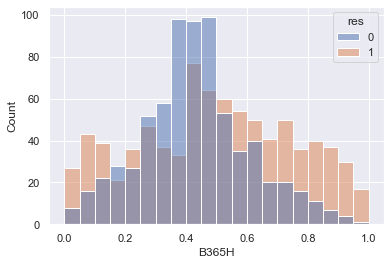

In [115]:
d = aux.sample(frac=1,axis=0)

# sns.relplot(
#     data=d,
#     x="B365H",y='B365A',
#     hue="res"
# )

sns.histplot(
    data=d,
    x="B365H",
    hue="res",
    stat='count',
    bins=20
)





<AxesSubplot:xlabel='B365A', ylabel='Count'>

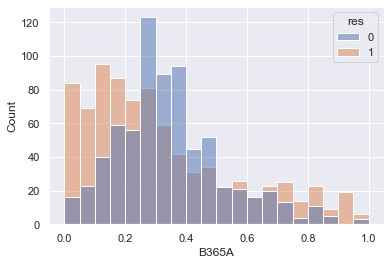

In [116]:
sns.histplot(
    data=d,
    x="B365A",
    hue="res",
    stat='count',
    bins=20
)

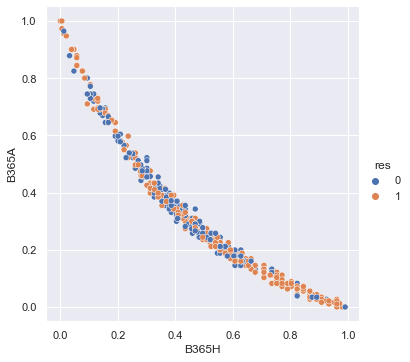

In [121]:
sns.relplot(
    data=d.sample(n=500,axis=0),
    x="B365H", y="B365A",
    hue="res"
)

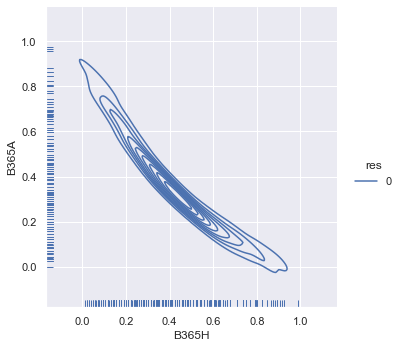

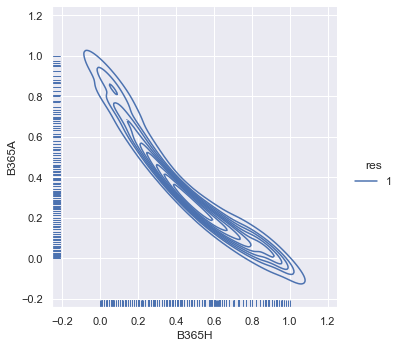

In [138]:
sns.displot(
    data=d[d['res']==0],
    x="B365H", y="B365A",
    hue='res',
    kind='kde', rug=True
)

sns.displot(
    data=d[d['res']==1],
    x="B365H", y="B365A",
    hue='res',
    kind='kde',rug=True, color='0f0f0f'
)

<h2><u>CUOTAS DB CON TENDENCIAS DE N PARTIDOS</u></h2><br>
probar con n menores

In [16]:
cuotasDB_tend5

B365H     B365A  res  tendencia_H  tendencia_A
0     0.416667  0.344828    1          2.2          1.8
1     0.250000  0.540541    1          2.4          2.6
2     0.322581  0.444444   -1          0.8          2.2
3     0.653595  0.173913   -1          1.4          1.4
4     0.653595  0.166667   -1          0.8          0.2
...        ...       ...  ...          ...          ...
1821  0.617284  0.181818    0          NaN          NaN
1822  0.125000  0.689655    0          NaN          NaN
1823  0.420168  0.312500    1          NaN          NaN
1824  0.571429  0.222222   -1          NaN          NaN
1825  0.487805  0.243902   -1          NaN          NaN

[1826 rows x 5 columns]

In [63]:
set(cuotasDB_tend5['res'])

{-1, 0, 1}

In [13]:
cuotasDB_tend5['B365H'] = [1/x for x in list(cuotasDB_tend5['B365H'])]
cuotasDB_tend5['B365A'] = [1/x for x in list(cuotasDB_tend5['B365A'])]

In [19]:
cuotasDB_tend5_norm = normalDB(db=cuotasDB_tend5) # por defecto usa MinMaxScaler
cuotasDB_tend5_norm

B365H     B365A  tendencia_H  tendencia_A  res
0     0.403808  0.368673     0.733333     0.600000    1
1     0.221443  0.597431     0.800000     0.866667    1
2     0.300860  0.485110     0.266667     0.733333   -1
3     0.663052  0.168900     0.466667     0.466667   -1
4     0.663052  0.160430     0.266667     0.066667   -1
...        ...       ...          ...          ...  ...
1575  0.509018  0.257834     0.333333     0.266667   -1
1576  0.039078  0.900700     0.333333     1.000000    1
1577  0.325202  0.452642     0.000000     0.466667    0
1578  0.012260  0.964637     0.000000     0.533333    1
1579  0.644831  0.145445     0.733333     0.866667   -1

[1580 rows x 5 columns]

In [20]:
d = cuotasDB_tend5_norm

In [21]:
sns.set_theme(style="darkgrid")

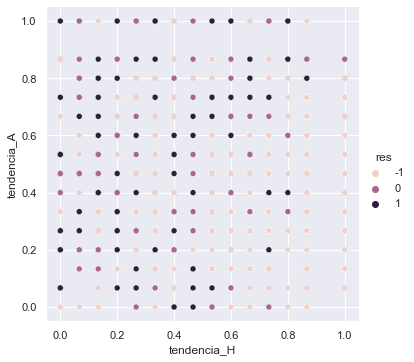

In [22]:
sns.relplot(
    x='tendencia_H', y='tendencia_A',
    data=d[['tendencia_H','tendencia_A','res']],
    hue='res'
)

Vamos a probar a transformar los atributos tendencia_H y tendencia_A a uno solo.

Este atributo será <b>dif_trend</b> y se calcula con la siguiente formula:

- dif_trend = tendenciaA - tendenciaH

Por tanto, si dif_trend < 0, el local habrá tenido una tendencia mejor, y si dif_trend > 0 al revés.

In [7]:
d = cuotasDB_tend5
dif_tend = [y-x for x,y in zip(d['tendencia_H'],d['tendencia_A'])]
assert len(dif_tend) == len(d)

In [8]:
qwe = cuotasDB_tend5.sample(n=50,random_state=2)
qwe = qwe.reset_index(drop=False)
qwe = qwe.dropna()
len(qwe)

41

In [9]:
# del(cuotasDB_diftend5_norm)
cuotasDB_diftend5_norm = cuotasDB_tend5
cuotasDB_diftend5_norm['dif_tend'] = dif_tend
cuotasDB_diftend5_norm = normalDB(cuotasDB_diftend5_norm)
cuotasDB_diftend5_norm = cuotasDB_diftend5_norm.drop(['tendencia_H', 'tendencia_A'], axis=1)
cuotasDB_diftend5_norm

B365H     B365A  dif_tend  res
0     0.068136  0.053848  0.413793    1
1     0.148297  0.021904  0.517241    1
2     0.103206  0.034074  0.724138   -1
3     0.024549  0.140554  0.482759   -1
4     0.024549  0.148159  0.379310   -1
...        ...       ...       ...  ...
1575  0.045591  0.087314  0.448276   -1
1576  0.549098  0.003651  0.827586    1
1577  0.093186  0.038637  0.724138    0
1578  0.799599  0.001217  0.758621    1
1579  0.026553  0.163371  0.551724   -1

[1580 rows x 4 columns]

In [10]:
# cuotasDB_diftend5_norm.to_csv('F:\\2020-21\\Beca VRAIN\\datasets\\data_train\\cuotasDB_diftend5_norm.csv',index=False)

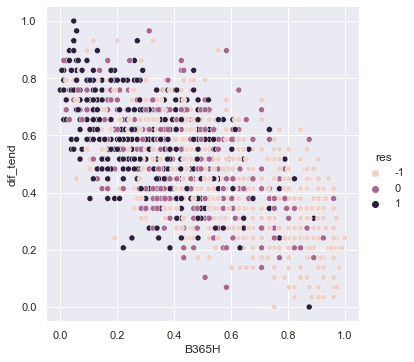

In [29]:
sns.relplot(
    x="B365H",y="dif_tend",hue="res",
    data=cuotasDB_diftend5_norm,
    kind='scatter')

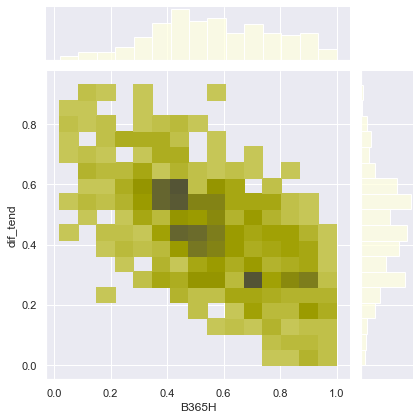

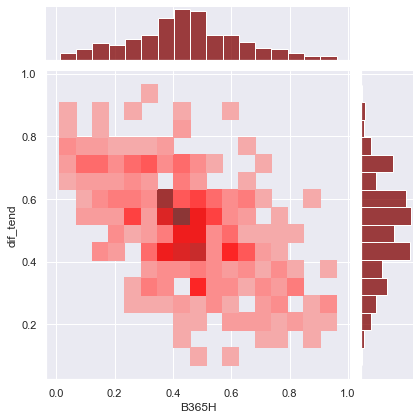

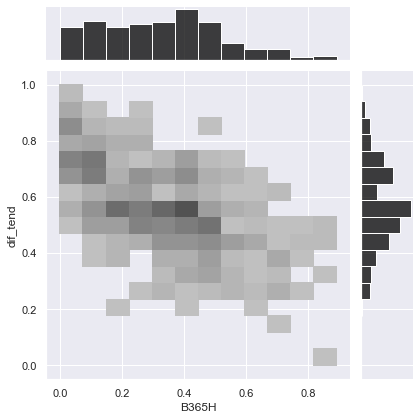

In [30]:
sns.jointplot(
    data=cuotasDB_diftend5_norm[cuotasDB_diftend5_norm['res']==-1],
    x='B365H',y='dif_tend',
    kind='hist', color='lightyellow'
)

sns.jointplot(
    data=cuotasDB_diftend5_norm[cuotasDB_diftend5_norm['res']==0],
    x='B365H',y='dif_tend',
    kind='hist',color='maroon',
)

sns.jointplot(
    data=cuotasDB_diftend5_norm[cuotasDB_diftend5_norm['res']==1],
    x='B365H',y='dif_tend',
    kind='hist',color='black',
)

Seria correcto aplicar una escala logarítma con el propósito de representar mejor los datos?

<h3>MODELOS DE PREDICCIÓN</h3>

In [31]:
assert len(cuotasDB_diftend5_norm) == 1580

In [32]:
trainDB,trainX,trainY,testX,testY = preprocessDB(cuotasDB_diftend5_norm,frac=0.85)

In [33]:
trainDB

B365H     B365A  dif_tend  res
553   0.368737  0.355238  0.413793   -1
353   0.353151  0.384564  0.655172    1
1376  0.365525  0.384564  0.620690    0
177   0.468938  0.277315  0.448276    1
267   0.980149  0.000000  0.137931   -1
...        ...       ...       ...  ...
79    0.012260  0.923693  0.827586    1
1438  0.752446  0.088659  0.379310    0
1424  0.891162  0.034378  0.275862   -1
687   0.445254  0.310415  0.482759   -1
166   0.459199  0.274025  0.482759    1

[1343 rows x 4 columns]

<h4>Árboles de Decisión</h4>

In [34]:
clf = tree.DecisionTreeClassifier()

In [35]:
results = cross_validate(clf,trainX,trainY,cv=5,return_estimator=True)
results['test_score'].mean()

0.44598568495810903

No hay una diferencia significativa entre la DB de tendencia A y B y la unificada.

In [38]:
clf_grid = GridSearchCV(estimator=clf, param_grid=param, cv=5)
clf_grid.fit(trainX,trainY)
clf_grid.best_score_

0.4519253176496698

In [39]:
clf_grid.best_params_

{'criterion': 'entropy', 'random_state': None, 'splitter': 'best'}

In [40]:
results = cross_validate(clf_grid,trainX,trainY,cv=5,return_estimator=True)
results

{'fit_time': array([0.15647697, 0.14860249, 0.14960003, 0.15062737, 0.14657688]),
 'score_time': array([0.00099754, 0.00099707, 0.00099707, 0.00099921, 0.00099707]),
 'estimator': [GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [None, 1],
                           'splitter': ['best', 'random']}),
  GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [None, 1],
                           'splitter': ['best', 'random']}),
  GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
                           'random_state': [None, 1],
                           'splitter': ['best', 'random']}),
  GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
               param_grid={'criterion': ['gini', 'entropy'],
    

In [41]:
results['test_score'].mean()

0.43929700937690724

Visualizamos los resultados

In [42]:
pred = cross_val_predict(clf,trainX,trainY,cv=5)
pred

array([ 1,  0,  0, ..., -1,  0,  1], dtype=int64)

In [43]:
trainY

553    -1
353     1
1376    0
177     1
267    -1
       ..
79      1
1438    0
1424   -1
687    -1
166     1
Name: res, Length: 1343, dtype: int64

In [44]:
res = [int(m==n) for m,n in zip(pred,trainY)]
aux = trainDB
aux['res'] = res
aux

B365H     B365A  dif_tend  res
553   0.368737  0.355238  0.413793    0
353   0.353151  0.384564  0.655172    0
1376  0.365525  0.384564  0.620690    1
177   0.468938  0.277315  0.448276    0
267   0.980149  0.000000  0.137931    1
...        ...       ...       ...  ...
79    0.012260  0.923693  0.827586    1
1438  0.752446  0.088659  0.379310    0
1424  0.891162  0.034378  0.275862    1
687   0.445254  0.310415  0.482759    0
166   0.459199  0.274025  0.482759    1

[1343 rows x 4 columns]

<AxesSubplot:xlabel='dif_tend', ylabel='Count'>

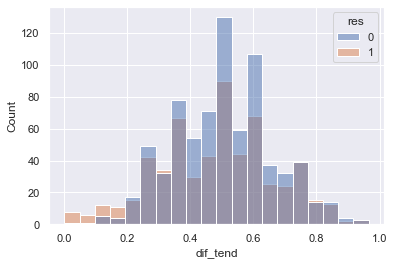

In [46]:
sns.histplot(
    data=aux,
    x="dif_tend",
    hue="res",
    stat='count',
    bins=20
)

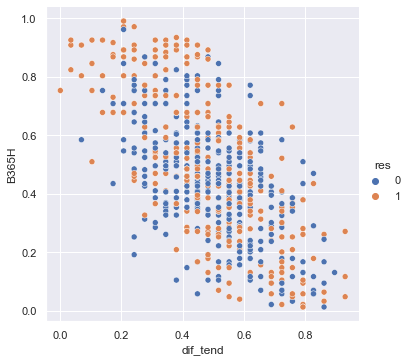

In [47]:
sns.relplot(
    data=aux.sample(frac=0.5,random_state=1),
    y="B365H",x="dif_tend",hue="res",
)

<h4>Naive Bayes</h4>

In [52]:
clf = GaussianNB()

results = cross_validate(clf,trainX,trainY,cv=5,return_estimator=True)
results['test_score'].mean()

0.6038894745602841

In [53]:
results['estimator'][0].n_features_in_

3

In [54]:
trainDB

B365H     B365A  dif_tend  res
553   0.368737  0.355238  0.413793    0
353   0.353151  0.384564  0.655172    0
1376  0.365525  0.384564  0.620690    1
177   0.468938  0.277315  0.448276    0
267   0.980149  0.000000  0.137931    1
...        ...       ...       ...  ...
79    0.012260  0.923693  0.827586    1
1438  0.752446  0.088659  0.379310    0
1424  0.891162  0.034378  0.275862    1
687   0.445254  0.310415  0.482759    0
166   0.459199  0.274025  0.482759    1

[1343 rows x 4 columns]

In [55]:
pred = cross_val_predict(clf,trainX,trainY,cv=5)
pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [56]:
trainY

553     0
353     0
1376    1
177     0
267     1
       ..
79      1
1438    0
1424    1
687     0
166     1
Name: res, Length: 1343, dtype: int64

In [57]:

res = [int(m==n) for m,n in zip(pred,trainY)]
aux = trainDB
aux['res'] = res
aux

B365H     B365A  dif_tend  res
553   0.368737  0.355238  0.413793    1
353   0.353151  0.384564  0.655172    1
1376  0.365525  0.384564  0.620690    0
177   0.468938  0.277315  0.448276    1
267   0.980149  0.000000  0.137931    1
...        ...       ...       ...  ...
79    0.012260  0.923693  0.827586    1
1438  0.752446  0.088659  0.379310    0
1424  0.891162  0.034378  0.275862    1
687   0.445254  0.310415  0.482759    1
166   0.459199  0.274025  0.482759    0

[1343 rows x 4 columns]

<AxesSubplot:xlabel='dif_tend', ylabel='Count'>

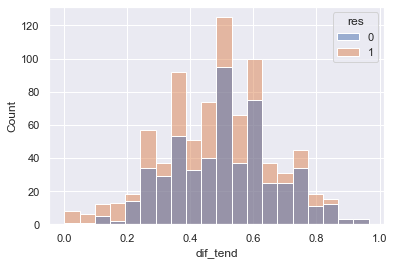

In [58]:
sns.histplot(
    data=aux,
    x="dif_tend",
    hue="res",
    stat='count',
    bins=20
)

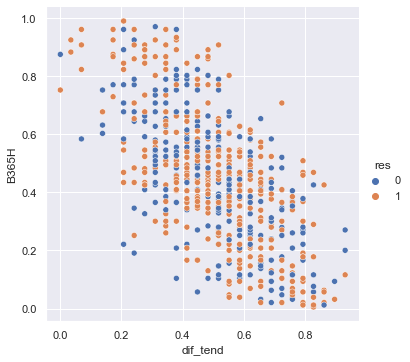

In [59]:
sns.relplot(
    data=aux.sample(frac=0.5,),
    y="B365H",x="dif_tend",hue="res",
)